# Librairies

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from dataclasses import dataclass
from typing import Tuple, List, Optional, Any

import os
import sys
import csv
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq


PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.looping_model import Pjump, Pjump_camembert

# Values

In [14]:
# --- PARAMETER STRUCTURES --- #

@dataclass
class RunConfig:
    """Container for physical simulation parameters."""
    xmin: int
    xmax: int
    bps: int
    x_array: np.ndarray
    t_array: np.ndarray
    Pzero: np.ndarray
    ryu_bin: int
    ryu_x: np.ndarray
    ryu_y: np.ndarray
    ryu_medians: np.ndarray
    folder_name: str = "probas_datas_opti"

@dataclass
class SimulationParams:
    """Container for run-specific configuration."""
    choice: str
    lp: float
    rcmin: float
    rcmax: float
    fnm: float
    width: float
    theta: float
    conv: float
    fbp: float

In [15]:
# Chromatin fiber
xmin = 1
xmax = 2_000
bps = 1
x_array = np.arange(xmin, xmax + bps, bps)
x_length = len(x_array)

# Times
t_array = np.logspace(start=1, stop=6, num=6, dtype=int)

# Parameters
choice_array = ["camembert", "sphere"]
lp_array = np.array([170])
rcmin_array = np.array([0])
rcmax_array = np.array([70, 140, 210, 280])
fnm_array = np.array([0, 0.2e-12, 0.3e-12, 0.4e-12, 0.5e-12, 0.6e-12, 0.7e-12, 1e-12])
width_array = np.array([1])
theta_array = np.array([np.pi])

# Conversion & Pzero
kb, T = 1.380649e-23, 300
conv_array = np.array([0.200e-9, 0.205e-9, 0.231e-9, 0.246e-9, 0.256e-9, 0.264e-9, 0.269e-9, 0.286e-9])
fbp_array = fnm_array / (kb * T) * conv_array
Pzero = np.array([1] + [0] * (x_length - 1))

# Env
print("Parameters loaded.")

# Ryu
ryu_bin = 41
ryu_x = np.array([-0.,          40.6504065,   81.30081301, 121.95121951, 162.60162602,
                   203.25203252, 243.90243902, 284.55284553, 325.20325203, 365.85365854,
                   406.50406504, 447.15447154, 487.80487805, 528.45528455, 569.10569106])
ryu_y = np.array([0.00752587, 0.13076199, 0.22859831, 0.18438382, 0.11476952, 0.11288805,
                  0.08654751, 0.05268109, 0.02634055, 0.02163688, 0.01317027, 0.00752587,
                  0.0084666,  0.0028222,  0.00188147])
ryu_medians = np.array([200, 170, 100, 120, 100, 90, 70])

Parameters loaded.


# Functions

In [16]:
# --- CALCULATIONS --- #

def sum_by_shifted_chunks(data: np.ndarray, chunk_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """Sum array over shifted non-overlapping chunks."""
    indices = np.arange(chunk_size // 2, len(data), chunk_size)
    summed_values = np.add.reduceat(data, indices)
    summed_values /= np.sum(summed_values)
    centers = indices + (chunk_size // 2)
    centers[-1] = min(centers[-1], len(data) - 1)
    return centers, summed_values

def find_median(distribution: np.ndarray, values: np.ndarray) -> float:
    """Return the value corresponding to the 50% cumulative probability."""
    distribution /= np.sum(distribution)
    cumsum = np.cumsum(distribution)
    idx = np.searchsorted(cumsum, 0.5)
    return values[idx]

def compute_fnm(fbp: float, conv: float, kb= 1.380649e-23, T=300):
    fnm = fbp * (kb * T) / conv
    return fnm

def compute_fbp(fnm: float, conv: float, kb= 1.380649e-23, T=300):
    fbp = fnm / (kb * T) * conv
    return fbp


# --- PROBABILITIES  --- #

def calculate_probabilities(cfg: RunConfig, params: SimulationParams) -> Tuple[np.ndarray, np.ndarray]:
    """Compute Peq and P based on the selected configuration."""
    if params.choice == 'sphere':
        P, Peq = Pjump(
            lengths=cfg.x_array,
            time=cfg.t_array,
            P0=cfg.Pzero,
            lp=params.lp,
            Rc=params.rcmax,
            Rmin=params.rcmin,
            f=params.fbp
        )
    elif params.choice == 'camembert':
        P, Peq = Pjump_camembert(
            lengths=cfg.x_array,
            time=cfg.t_array,
            P0=cfg.Pzero,
            lp=params.lp,
            Rc=params.rcmax,
            Width=params.width,
            f=params.fbp,
            thetaf=params.theta
        )
    else:
        raise ValueError(f"Unknown choice: {params.choice}")

    P = np.transpose(P)
    return Peq, P

def run_single_proba(cfg: RunConfig, params: SimulationParams):
    """Run a single probability calculation and return results."""
    print(f"Running config: choice={params.choice}, lp={params.lp}, rcmin={params.rcmin}, rcmax={params.rcmax}bp, fbp={params.fbp:.10e}, theta={params.theta:.10e}")
    Peq, P = calculate_probabilities(cfg, params)
    P_points, Peq_summed = sum_by_shifted_chunks(Peq, cfg.ryu_bin)
    P_summed = [sum_by_shifted_chunks(P[i], cfg.ryu_bin)[1] for i in range(len(cfg.t_array))]
    medians = [find_median(P[i], cfg.x_array) for i in range(len(cfg.t_array))]
    return P_points, Peq, Peq_summed, P, P_summed, medians


# --- WRITING / READING --- #

def convert_to_serializable(value: Any) -> Any:
    """Convert NumPy types and arrays into serializable Python types."""
    if isinstance(value, np.generic):
        return value.item()
    elif isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, list):
        return [convert_to_serializable(v) for v in value]
    else:
        return value

def writing_parquet(filename: str, folder: str, data: dict) -> None:
    """ Write a dictionary to a compressed Parquet file using PyArrow. """
    out_path = os.path.join(folder, f"{filename}_{os.path.basename(folder)}.parquet")
    prepared_data = {
        k: [convert_to_serializable(v)] if not isinstance(v, list) else [convert_to_serializable(v)]
        for k, v in data.items()
    }
    try:
        table = pa.table(prepared_data)
        pq.write_table(table, out_path, compression='gzip')
    except Exception as e:
        print(f"[ERROR] Failed to write Parquet file: {e}")

def save_results(cfg: RunConfig, params: SimulationParams, results: Tuple):
    """Save results to disk as Parquet."""
    os.makedirs(cfg.folder_name, exist_ok=True)
    filename = f"{params.choice}_lp{params.lp}_rcmin{params.rcmin}_rcmax{params.rcmax}_Fnm{params.fnm}_Width{params.width}_Theta{params.theta}_conv{params.conv}"
    data = dict(zip(["P_points", "Peq", "Peq_summed", "P", "P_summed", "medians"], results))
    writing_parquet(filename, cfg.folder_name, data)

def read_results(cfg: RunConfig, params: SimulationParams) -> dict:
    """Load result from a saved Parquet file."""
    filename = f"{params.choice}_lp{params.lp}_rcmin{params.rcmin}_rcmax{params.rcmax}_Fnm{params.fnm}_Width{params.width}_Theta{params.theta}_conv{params.conv}"
    path = os.path.join(cfg.folder_name, f"{filename}_{os.path.basename(cfg.folder_name)}.parquet")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Missing result: {path}")
    df = pl.read_parquet(path)
    return {k: df[k].to_numpy()[0] for k in df.columns}


# --- WRAPPER / PLOTTING --- #

def full_run(cfg: RunConfig, params: SimulationParams):
    """Run one simulation and save results."""
    results = run_single_proba(cfg, params)
    save_results(cfg, params, results)
    return results

def plot_one(ax, cfg: RunConfig, params: SimulationParams, result_dict: dict, t_array: np.ndarray):
    """Plot Peq and P curves for one simulation on a matplotlib axis."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_title(f"{params.choice}\nrcmax={params.rcmax}bp | F={params.fnm:.2e}pN")
    ax.plot(cfg.ryu_x, cfg.ryu_y, marker='o', label='Ryu data', ls='-', color='grey', markeredgecolor='black')
    ax.plot(cfg.x_array, result_dict["Peq"], marker='+', label='Peq', ls='--', c='k')
    # ax.plot(result_dict["P_points"], result_dict["Peq_summed"], marker='o', ls='-', label='Peq binned', c='r')

    cmap = plt.get_cmap('plasma')
    n_curves = len(t_array)
    colors = [cmap(i / (n_curves - 1)) for i in range(n_curves)]

    for i, P_t in enumerate(result_dict["P"]):
        color = colors[i]
        ax.plot(cfg.x_array, P_t, marker='+', label=f'P t={t_array[i]}', ls='--', color=color)
        # ax.plot(result_dict["P_points"], result_dict["P_summed"][i], marker='o', label=f'P_bin t={t_array[i]}', ls='-', color=color)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e0, 2 * cfg.xmax)
    ax.set_ylim(1e-15, 1e0)
    ax.legend(fontsize=7, loc='lower left')
    ax.grid(True, which='both')


# --- MULTI RUN & PLOT --- #

def run_multiple(cfg_template: RunConfig, param_grid: List[SimulationParams], t_array: np.ndarray, output_csv: str = "all_medians.csv"):
    """Run all parameter combinations and save results (no plots)."""
    rows = []
    header = ["choice", "rcmax", "fbp"] + [f"median_t{t}" for t in t_array]
    rows.append(header)

    pbar = tqdm(total=len(param_grid), desc="Running simulations")

    for params in param_grid:
        cfg = cfg_template
        results = full_run(cfg, params)
        save_results(cfg, params, results)

        result_dict = read_results(cfg, params)
        row_data = [params.choice, params.rcmax, params.fbp] + list(result_dict["medians"])
        rows.append(row_data)

        pbar.update(1)

    pbar.close()

    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(rows)

def plot_multiple(cfg_template: RunConfig, param_grid: List[SimulationParams], t_array: np.ndarray, output_fig: str = "all_probas_results.png"):
    """Reload results from disk and generate plots only."""
    nrows = len(set(p.rcmax for p in param_grid))
    ncols = len(set((p.fbp, p.choice) for p in param_grid))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axes = np.array(axes, dtype=object).reshape(nrows, ncols)

    pbar = tqdm(total=len(param_grid), desc="Plotting simulations")

    for idx, params in enumerate(param_grid):
        row, col = idx // ncols, idx % ncols
        cfg = cfg_template

        # Relire depuis disque
        result_dict = read_results(cfg, params)

        # Tracer sur l'axe
        ax = axes[row, col]
        plot_one(ax, cfg, params, result_dict, t_array)
        pbar.update(1)

    pbar.close()
    plt.tight_layout()
    plt.savefig(output_fig, dpi=300)

In [17]:
# One call parameters
lp = lp_array[0]
rcmin = rcmin_array[0]
rcmax = rcmax_array[3]
width = width_array[0]
theta = theta_array[0]

# Force selection
rank_test = 1
fnm = fnm_array[rank_test]
conv = conv_array[rank_test]
fbp = fbp_array[rank_test]
choice_test = choice_array[0]

# Run
cfg = RunConfig(
    xmin=xmin,
    xmax=xmax,
    bps=bps,
    x_array=x_array,
    t_array=t_array,
    Pzero=Pzero,
    ryu_bin=ryu_bin,
    ryu_x=ryu_x,
    ryu_y=ryu_y,
    ryu_medians=ryu_medians,
    folder_name="/home/nicolas/Documents/Workspace/ploop/outputs/probas"
)

params = SimulationParams(
    choice=choice_test,
    lp=lp,
    rcmin=rcmin,
    rcmax=rcmax,
    fnm=fnm,
    width=width,
    theta=theta,
    conv=conv,
    fbp=fbp
)

results = full_run(cfg, params)
save_results(cfg, params, results)

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


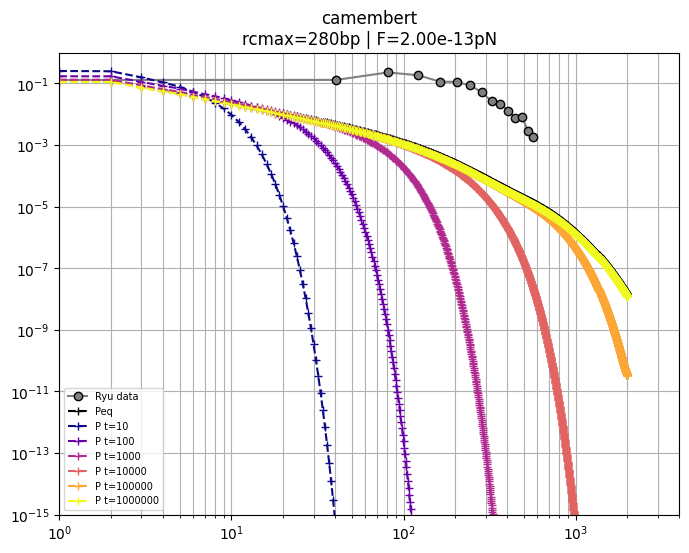

In [18]:
plot_one(ax=None, cfg=cfg, params=params, result_dict=read_results(cfg=cfg, params=params), t_array=t_array)

In [19]:
# 1. cfg_template
cfg_template = RunConfig(
    xmin=xmin,
    xmax=xmax,
    bps=bps,
    x_array=x_array,
    t_array=t_array,
    Pzero=Pzero,
    ryu_bin=ryu_bin,
    ryu_x=ryu_x,
    ryu_y=ryu_y,
    ryu_medians=ryu_medians
)

# 2. param_grid
param_grid = [
    SimulationParams(
        choice=choice,
        lp=lp,
        rcmin=rcmin,
        rcmax=rcmax,
        fnm=compute_fnm(fbp, conv),
        width=width,
        theta=theta,
        conv=conv,
        fbp=fbp
    )
    for choice in choice_array
    for rcmin in rcmin_array
    for rcmax in rcmax_array
    for fbp, conv in zip(fbp_array, conv_array)
]

In [20]:
# 3. run_multiple
run_multiple(cfg_template, param_grid, t_array)

Running simulations:   0%|          | 0/64 [00:00<?, ?it/s]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:   2%|▏         | 1/64 [08:12<8:37:10, 492.54s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:   3%|▎         | 2/64 [16:22<8:27:38, 491.27s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:   5%|▍         | 3/64 [24:24<8:14:59, 486.87s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:   6%|▋         | 4/64 [32:31<8:06:56, 486.93s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:   8%|▊         | 5/64 [40:29<7:55:45, 483.82s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:   9%|▉         | 6/64 [48:29<7:46:14, 482.32s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  11%|█         | 7/64 [56:18<7:34:07, 478.02s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=70bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations:  12%|█▎        | 8/64 [1:03:56<7:20:12, 471.66s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:  14%|█▍        | 9/64 [1:13:39<7:44:09, 506.36s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:  16%|█▌        | 10/64 [1:23:17<7:55:37, 528.48s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:  17%|█▋        | 11/64 [1:32:39<7:55:55, 538.79s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:  19%|█▉        | 12/64 [1:42:08<7:54:56, 548.01s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:  20%|██        | 13/64 [1:51:32<7:49:55, 552.86s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:  22%|██▏       | 14/64 [2:00:47<7:41:15, 553.52s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  23%|██▎       | 15/64 [2:09:51<7:29:42, 550.66s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=140bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations:  25%|██▌       | 16/64 [2:18:37<7:14:34, 543.21s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:  27%|██▋       | 17/64 [2:31:30<7:59:32, 612.19s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:  28%|██▊       | 18/64 [2:44:21<8:25:55, 659.90s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:  30%|██▉       | 19/64 [2:56:41<8:32:59, 684.00s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:  31%|███▏      | 20/64 [3:09:14<8:36:47, 704.71s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:  33%|███▎      | 21/64 [3:21:19<8:29:24, 710.81s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:  34%|███▍      | 22/64 [3:33:26<8:21:02, 715.77s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  36%|███▌      | 23/64 [3:46:45<8:26:14, 740.83s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=210bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations:  38%|███▊      | 24/64 [3:59:37<8:20:05, 750.14s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:  39%|███▉      | 25/64 [4:12:43<8:14:30, 760.79s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:  41%|████      | 26/64 [4:25:05<7:58:16, 755.17s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:  42%|████▏     | 27/64 [4:37:20<7:42:04, 749.31s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:  44%|████▍     | 28/64 [4:49:27<7:25:24, 742.34s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:  45%|████▌     | 29/64 [5:02:09<7:16:36, 748.46s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:  47%|████▋     | 30/64 [5:14:28<7:02:32, 745.65s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  48%|████▊     | 31/64 [5:26:32<6:46:26, 739.00s/it]

Running config: choice=camembert, lp=170, rcmin=0, rcmax=280bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations:  50%|█████     | 32/64 [5:38:03<6:26:29, 724.67s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:  52%|█████▏    | 33/64 [5:42:55<5:07:17, 594.75s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:  53%|█████▎    | 34/64 [5:47:42<4:11:19, 502.63s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:  55%|█████▍    | 35/64 [5:52:31<3:31:50, 438.30s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:  56%|█████▋    | 36/64 [5:57:18<3:03:28, 393.16s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:  58%|█████▊    | 37/64 [6:02:06<2:42:39, 361.48s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:  59%|█████▉    | 38/64 [6:06:52<2:26:50, 338.86s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  61%|██████    | 39/64 [6:11:45<2:15:27, 325.11s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=70bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations:  62%|██████▎   | 40/64 [6:16:30<2:05:13, 313.05s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:  64%|██████▍   | 41/64 [6:21:21<1:57:28, 306.45s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:  66%|██████▌   | 42/64 [6:26:11<1:50:30, 301.40s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:  67%|██████▋   | 43/64 [6:31:02<1:44:26, 298.42s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:  69%|██████▉   | 44/64 [6:35:51<1:38:32, 295.64s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:  70%|███████   | 45/64 [6:40:44<1:33:19, 294.69s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:  72%|███████▏  | 46/64 [6:45:35<1:28:07, 293.78s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  73%|███████▎  | 47/64 [6:50:26<1:22:58, 292.86s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=140bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations:  75%|███████▌  | 48/64 [6:55:20<1:18:08, 293.06s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:  77%|███████▋  | 49/64 [7:00:11<1:13:08, 292.57s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:  78%|███████▊  | 50/64 [7:04:58<1:07:53, 290.96s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:  80%|███████▉  | 51/64 [7:09:47<1:02:51, 290.15s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:  81%|████████▏ | 52/64 [7:14:36<58:00, 290.07s/it]  

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:  83%|████████▎ | 53/64 [7:19:28<53:15, 290.54s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:  84%|████████▍ | 54/64 [7:24:21<48:33, 291.37s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  86%|████████▌ | 55/64 [7:29:13<43:42, 291.37s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=210bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations:  88%|████████▊ | 56/64 [7:34:02<38:45, 290.67s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=0.0000000000e+00, theta=3.1415926536e+00


Running simulations:  89%|████████▉ | 57/64 [7:38:43<33:33, 287.68s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=9.8987263719e-03, theta=3.1415926536e+00


Running simulations:  91%|█████████ | 58/64 [7:43:32<28:48, 288.16s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=1.6731261892e-02, theta=3.1415926536e+00


Running simulations:  92%|█████████▏| 59/64 [7:48:19<24:00, 288.02s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=2.3756943293e-02, theta=3.1415926536e+00


Running simulations:  94%|█████████▍| 60/64 [7:53:06<19:10, 287.62s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=3.0903340868e-02, theta=3.1415926536e+00


Running simulations:  95%|█████████▌| 61/64 [7:57:56<14:25, 288.33s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=3.8242884325e-02, theta=3.1415926536e+00


Running simulations:  97%|█████████▋| 62/64 [8:02:48<09:38, 289.46s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=4.5461711606e-02, theta=3.1415926536e+00


Running simulations:  98%|█████████▊| 63/64 [8:07:36<04:48, 288.94s/it]

Running config: choice=sphere, lp=170, rcmin=0, rcmax=280bp, fbp=6.9049652253e-02, theta=3.1415926536e+00


Running simulations: 100%|██████████| 64/64 [8:12:30<00:00, 461.73s/it]


Plotting simulations: 100%|██████████| 64/64 [00:00<00:00, 119.01it/s]


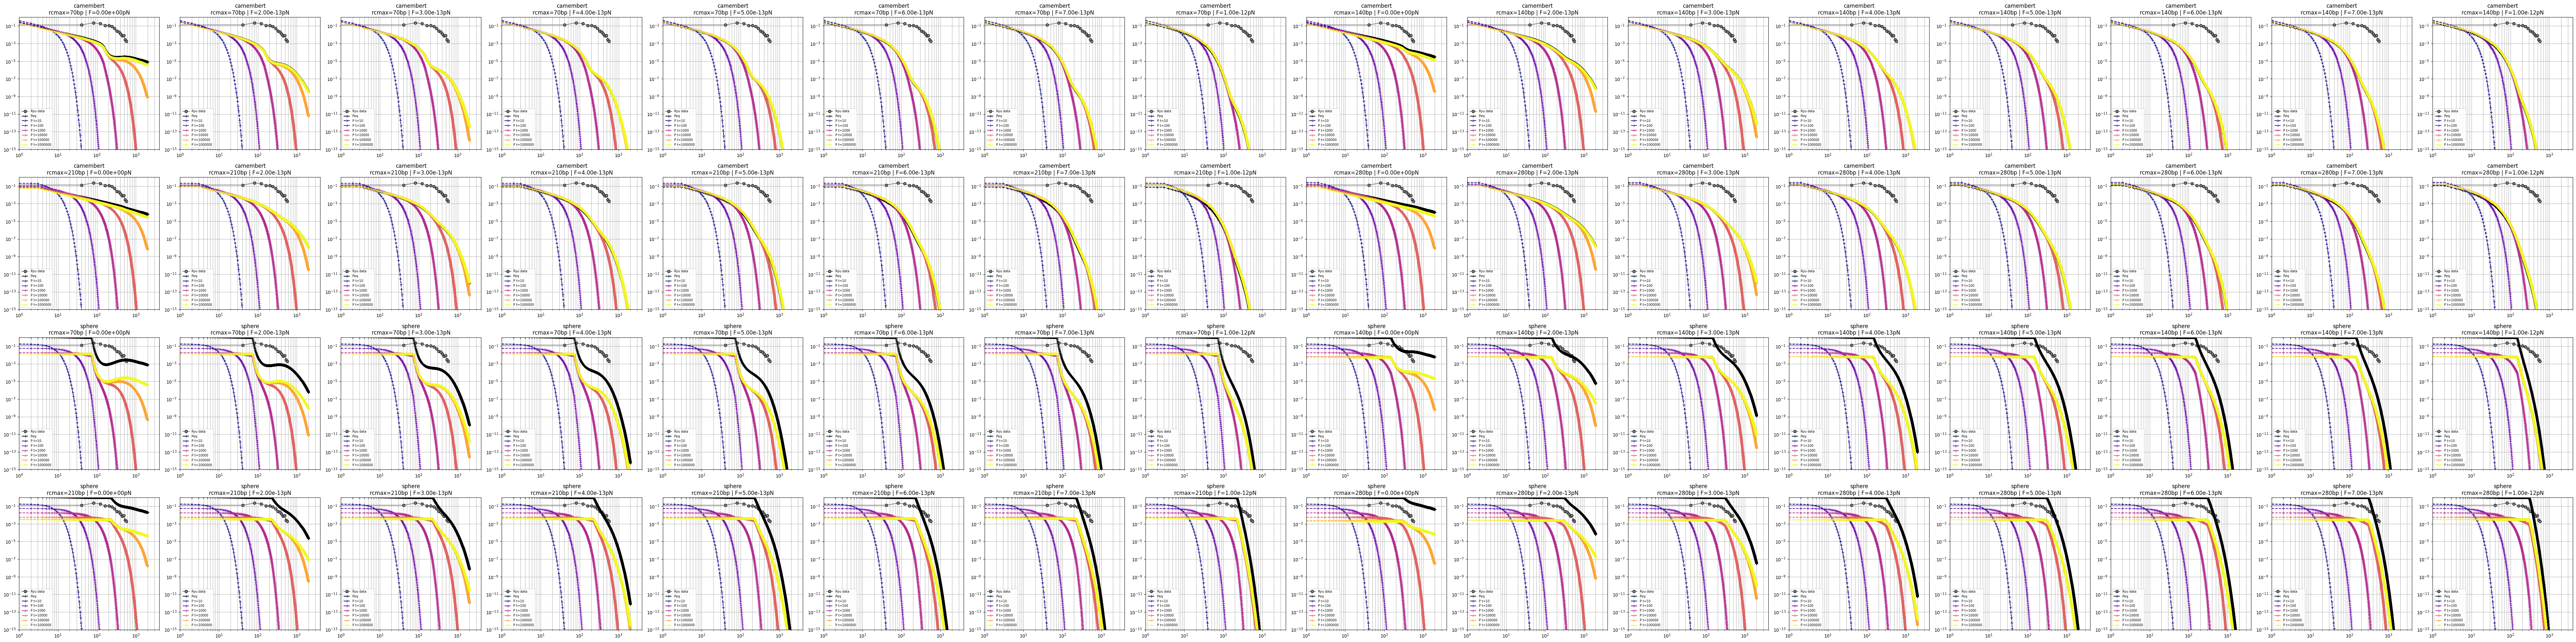

In [21]:
plot_multiple(cfg_template, param_grid, t_array)

In [22]:
def load_medians_csv(csv_path: str = "all_medians.csv") -> pd.DataFrame:
    """
    Load medians CSV as a pandas DataFrame.

    Returns:
        pd.DataFrame with columns: 'choice', 'rcmax', 'fbp', 'median_t1', ...
    """
    df = pl.read_csv(csv_path).to_pandas()
    print(f"Loaded {csv_path} with shape {df.shape}")
    return df

def filter_by_choice(df: pd.DataFrame, choice: str) -> pd.DataFrame:
    """Filter medians DataFrame for a specific simulation choice."""
    return df[df["choice"] == choice].copy()

def plot_medians_vs_time(
    df: pd.DataFrame,
    rcmax_array: np.ndarray,
    fnm_array: np.ndarray,
    t_array: np.ndarray,
):
    """
    Plot medians as a function of time (log-log) for each rcmax × fbp.
    """
    nrows, ncols = len(rcmax_array), len(fnm_array)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)

    for i, rc in enumerate(rcmax_array):
        for j, fnm in enumerate(fnm_array):
            ax = axes[i][j]
            row = df[(df["rcmax"] == rc) & (np.isclose(df["fbp"], fnm, atol=1e-6))]
            if row.empty:
                ax.set_visible(False)
                continue
            medians = row.iloc[0, 3:].values
            ax.plot(t_array, medians, marker='o', linestyle='-')
            ax.set_title(f'rc={rc} bp | F={fnm_array[j]:.1f} pN')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, which='both')
            ax.set_xlabel('Time (t)')
            ax.set_ylabel('Median (bp)')

    plt.tight_layout()
    plt.show()

def plot_medians_vs_force(
    df: pd.DataFrame,
    rcmax_array: np.ndarray,
    fnm_array: np.ndarray,
    t_array: np.ndarray,
    ryu_medians: np.ndarray
):
    """
    Plot median vs force for each time point, grouped by Rc.
    """
    fig, axes = plt.subplots(1, len(t_array), figsize=(5 * len(t_array), 4))
    if len(t_array) == 1:
        axes = [axes]

    for idx, t in enumerate(t_array):
        ax = axes[idx]
        for rc in rcmax_array:
            subset = df[df["rcmax"] == rc].sort_values("fbp")
            y = subset.iloc[:, 3 + idx].values
            if len(y) != len(fnm_array):
                continue
            ax.plot(fnm_array, y, marker='o', linestyle='--', label=f'rc={rc} bp')

        if ryu_medians is not None:
            factor = 20
            ax.plot(fnm_array[1:], ryu_medians/factor, marker='o', color='k', label=f'Ryu/{factor}')

        ax.set_title(f't={t}')
        ax.set_xlabel("Force (N)")
        ax.set_ylabel("Median (bp)")
        ax.grid(True, which='both')
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_medians_vs_force_per_Rc(
    df: pd.DataFrame,
    rcmax_array: np.ndarray,
    fnm_array: np.ndarray,
    t_array: np.ndarray,
    ryu_medians: np.ndarray
):
    """
    Plot median vs force per rcmax, with one subplot per Rc and curves per t.
    """
    fig, axes = plt.subplots(1, len(rcmax_array), figsize=(5 * len(rcmax_array), 4))
    if len(rcmax_array) == 1:
        axes = [axes]

    for idx, rc in enumerate(rcmax_array):
        ax = axes[idx]
        subset = df[df["rcmax"] == rc].sort_values("fbp")
        if len(subset) != len(fnm_array):
            continue
        for i, t in enumerate(t_array):
            y = subset.iloc[:, 3 + i].values
            ax.plot(fnm_array, y, marker='o', linestyle='--', label=f't={t}')

        if ryu_medians is not None:
            factor = 20
            ax.plot(fnm_array[1:], ryu_medians/factor, marker='o', color='k', label=f'Ryu/{factor}')

        ax.set_title(f'rc={rc}')
        ax.set_xlabel("Force (N)")
        ax.set_ylabel("Median (bp)")
        ax.grid(True, which='both')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [23]:
df = load_medians_csv("all_medians.csv")
df_choice = filter_by_choice(df, choice="camembert")
print(df_choice)

Loaded all_medians.csv with shape (64, 9)
       choice  rcmax       fbp  median_t10  median_t100  median_t1000  \
0   camembert     70  0.000000           2            3             5   
1   camembert     70  0.009899           2            3             4   
2   camembert     70  0.016731           2            3             4   
3   camembert     70  0.023757           2            3             4   
4   camembert     70  0.030903           2            3             3   
5   camembert     70  0.038243           2            3             3   
6   camembert     70  0.045462           2            3             3   
7   camembert     70  0.069050           2            2             3   
8   camembert    140  0.000000           2            3             5   
9   camembert    140  0.009899           2            3             5   
10  camembert    140  0.016731           2            3             4   
11  camembert    140  0.023757           2            3             4   
12  camem

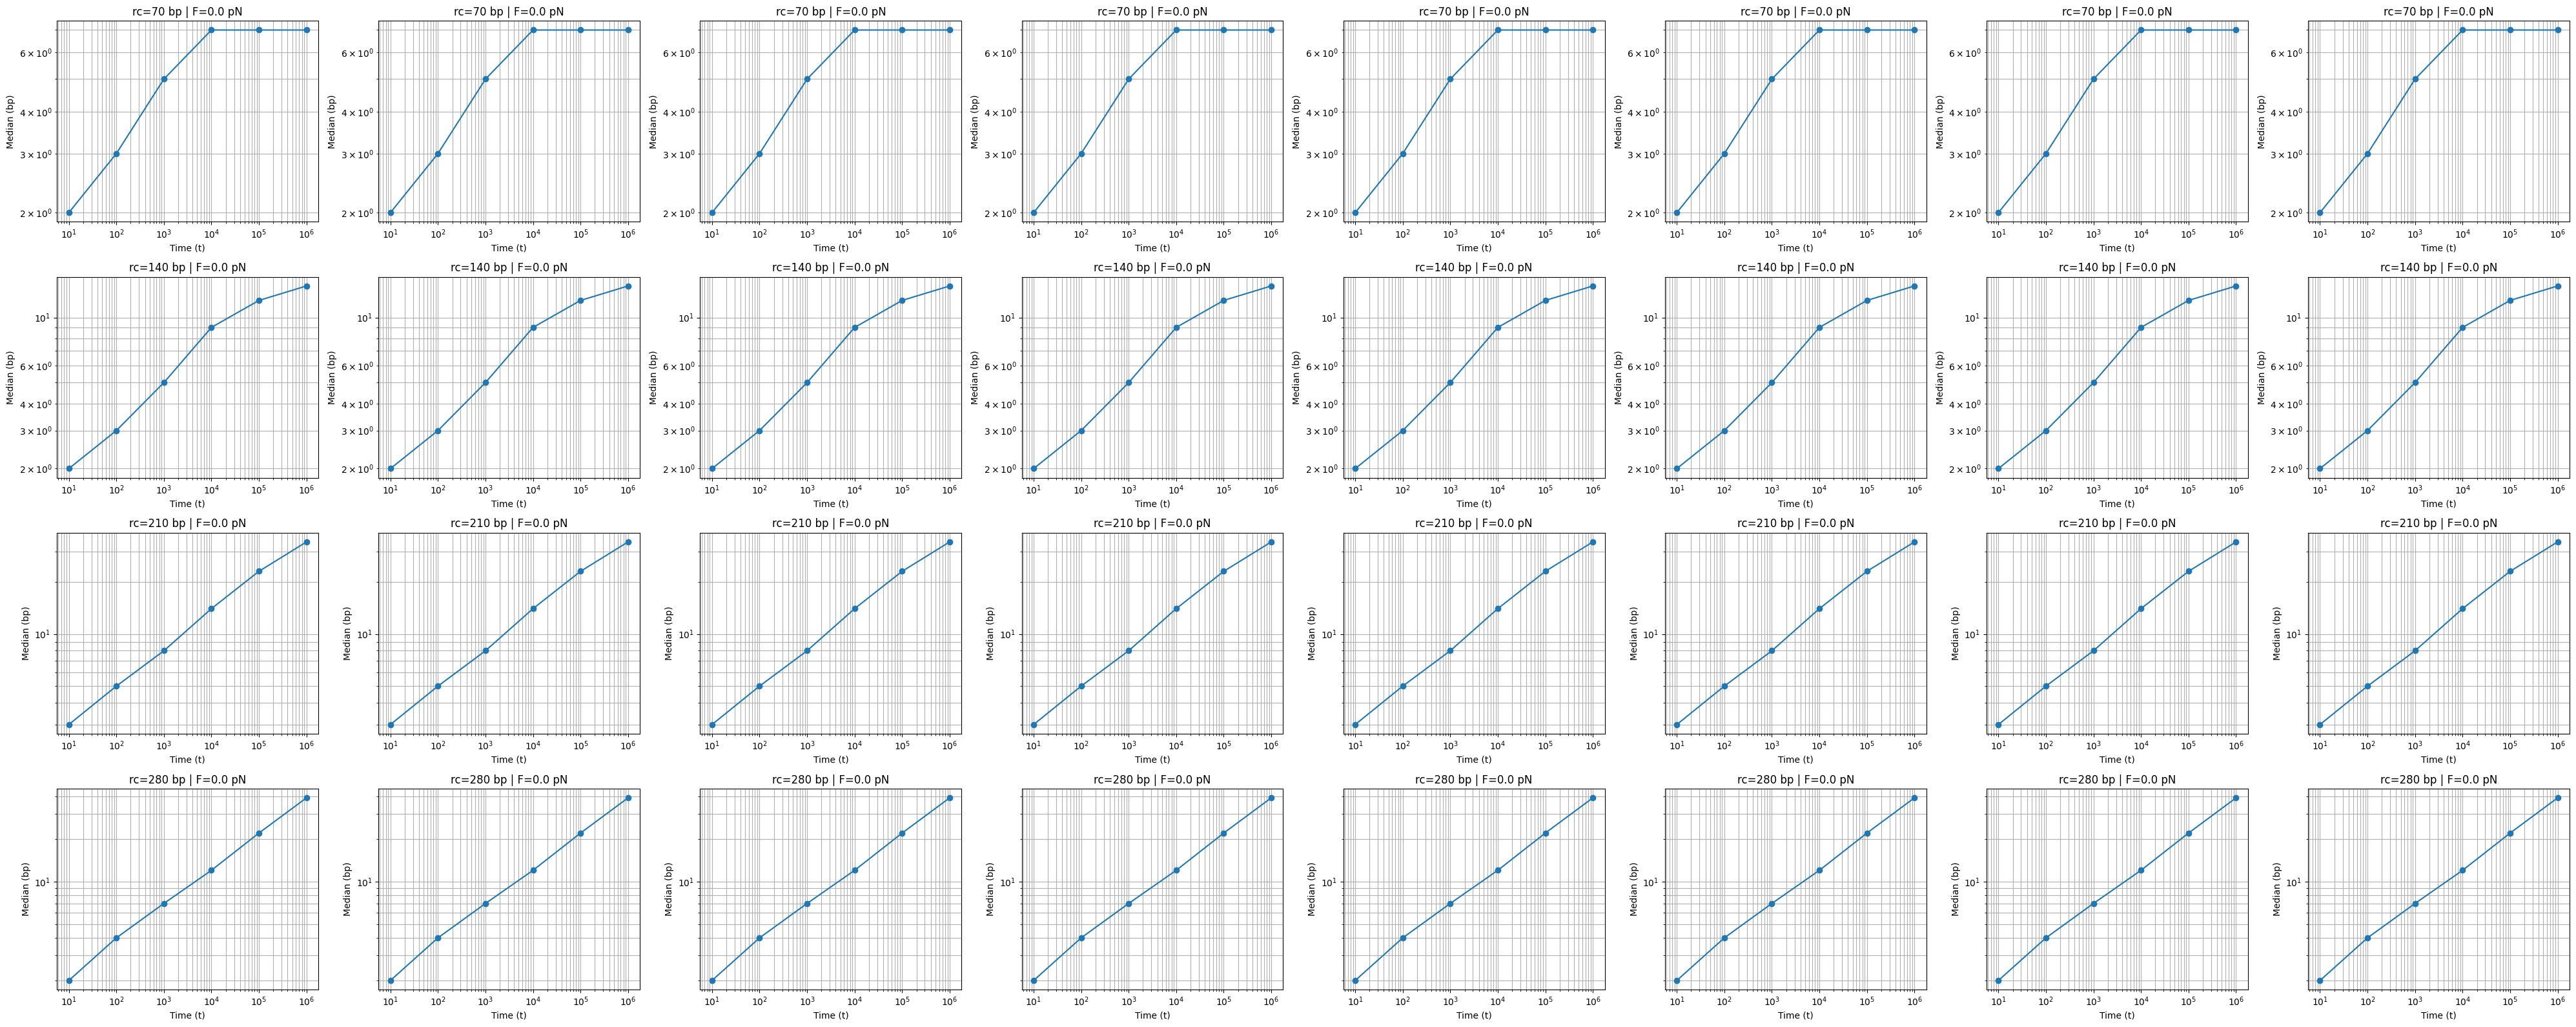

In [24]:
plot_medians_vs_time(df_choice, rcmax_array, fnm_array, t_array)

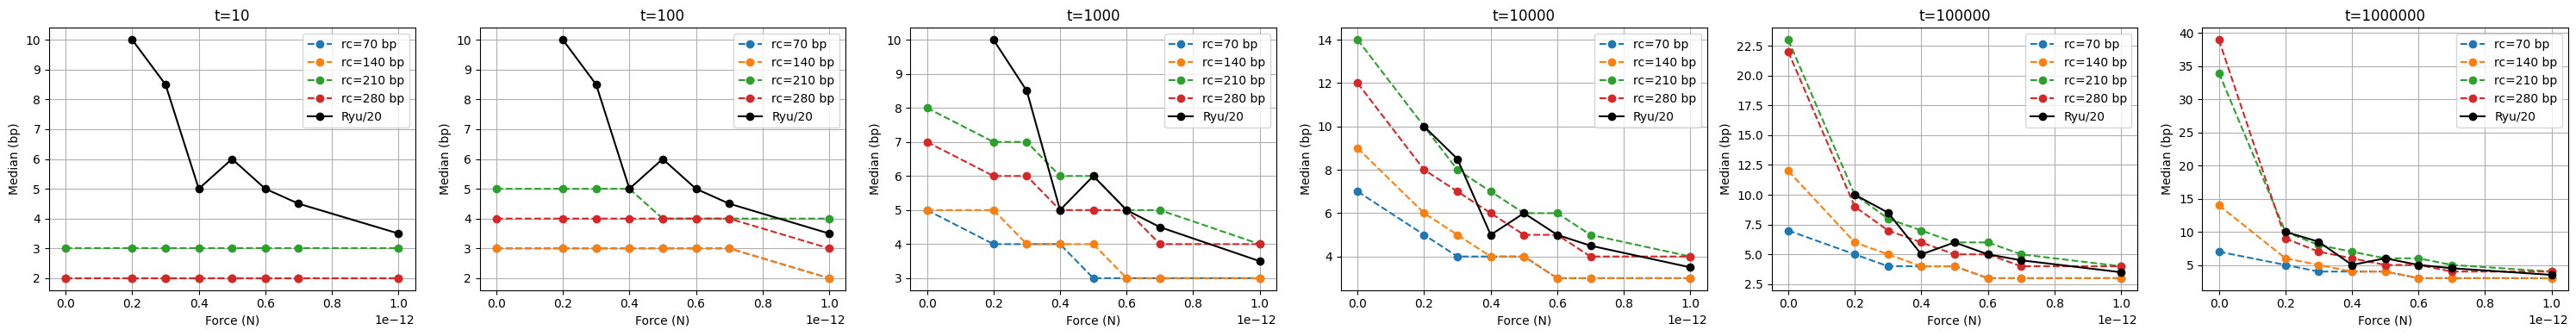

In [25]:
plot_medians_vs_force(df_choice, rcmax_array, fnm_array, t_array, ryu_medians)

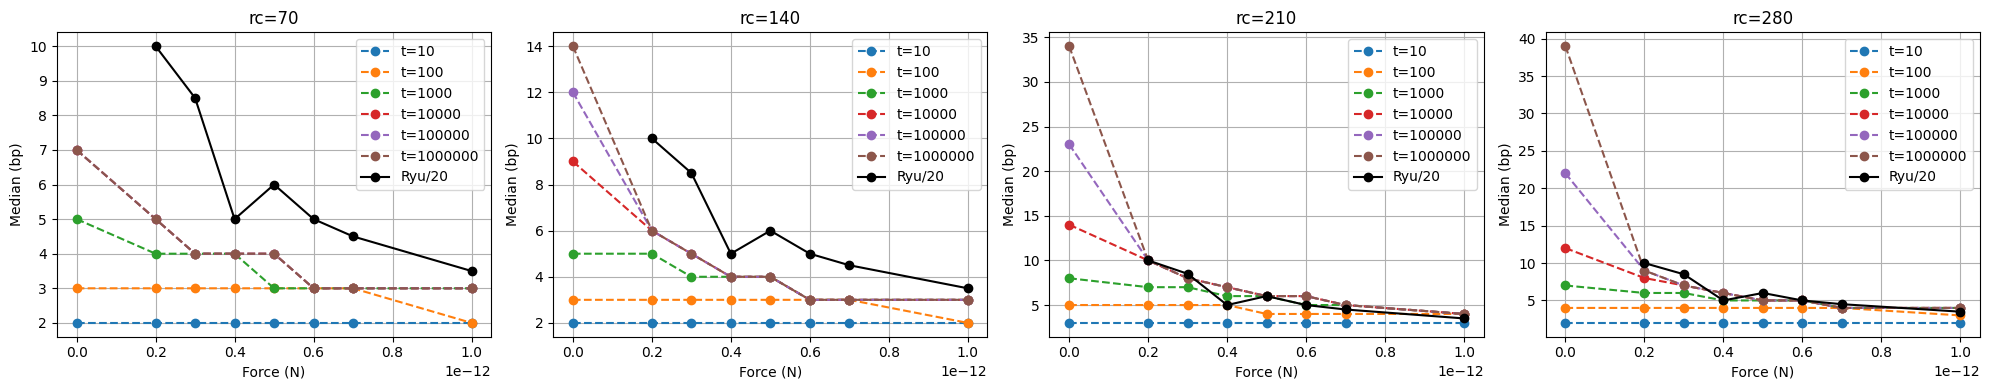

In [26]:
plot_medians_vs_force_per_Rc(df_choice, rcmax_array, fnm_array, t_array, ryu_medians)

# .